### Bayesian Optimization

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import time

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
train_freq_loans = pd.read_csv('./data/train_freq_loans.csv')
test_freq_loans = pd.read_csv('./data/test_freq_loans.csv')
print train_freq_loans.shape, test_freq_loans.shape

(86386, 196) (11170, 196)


In [4]:
test_freq_loans.columns

Index([u'loan_amnt', u'term', u'int_rate', u'installment', u'emp_length',
       u'annual_inc', u'dti', u'delinq_2yrs', u'inq_last_6mths',
       u'mths_since_last_delinq',
       ...
       u'107', u'108', u'109', u'110', u'111', u'112', u'emp_title', u'title',
       u'zip_code', u'loan_status'],
      dtype='object', length=196)

In [5]:
def xgb_fit(xgb_estimator, train_data, test_data, predictors, label, cv=True, cv_folds=3, early_stopping_rounds=50):
    """
    Function to fit the XGBoosting
    """
    start_time = time.time()
    if cv:
        params = xgb_estimator.get_xgb_params()
        train = xgb.DMatrix(train_data[predictors].values, label=train_data[label].values)
        cv_results = xgb.cv(params, train, num_boost_round=xgb_estimator.get_params()['n_estimators'], nfold=cv_folds, metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        xgb_estimator.set_params(n_estimators=cv_results.shape[0])
    
    # fit xgboosting on train data
    xgb_estimator.fit(train_data[predictors], train_data[label], eval_metric=['auc'])
        
    # predict the train data
    train_preds = xgb_estimator.predict(train_data[predictors])
    train_preds_proba = xgb_estimator.predict_proba(train_data[predictors])[:,1]
    
    # predict the test data
    test_preds = xgb_estimator.predict(test_data[predictors])
    test_preds_proba = xgb_estimator.predict_proba(test_data[predictors])[:,1]
    
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # report model performance
    print "\nModel Performance"
    print "Accuracy : %.4g" % metrics.accuracy_score(train_data[label].values, train_preds)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(train_data[label], train_preds_proba)
    print "AUC Score (Test): %f" % metrics.roc_auc_score(test_data[label], test_preds_proba)
                    
    feature_importance = pd.Series(xgb_estimator.booster().get_fscore()).sort_values(ascending=False)
    feature_importance.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Determin parameters priors range based on previous work

In [6]:
predictors = [x for x in train_freq_loans.columns if x not in ['loan_status']]

In [72]:
# n_estimators = 145, max_depth = 5, min_child_weight = 1, gamma = 0, subsample, colsample_bytree = 0.8, scale_pos_weight = 1
xgb1 = XGBClassifier(learning_rate = 0.1, 
                     n_estimators=500, 
                     max_depth=5, 
                     min_child_weight=1, 
                     gamma=0, 
                     subsample=0.8, 
                     colsample_bytree=0.8, 
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 131



Model Performance
Accuracy : 0.8097
AUC Score (Train): 0.826138
AUC Score (Test): 0.822869


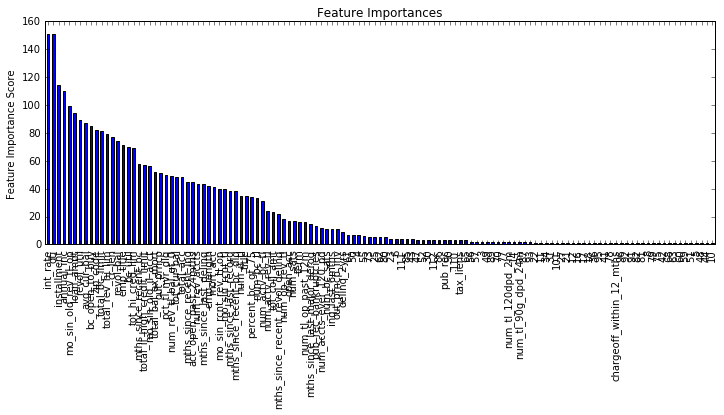

In [73]:
xgb_fit(xgb1, train_freq_loans, test_freq_loans, predictors, 'loan_status')

In [75]:
print 'best number of estimators: {}'.format(xgb1.n_estimators)

best number of estimators: 132


### Step 2: grid seach on max_depth

In [14]:
param2 = {
    'max_depth':range(3,10,2),
#     'min_child_weight':range(1,6,2)
}

In [15]:
xgb2 = XGBClassifier(learning_rate =0.1, 
                     n_estimators=132, 
                     max_depth=5,
                     min_child_weight=1, 
                     gamma=0, 
                     subsample=0.8, 
                     colsample_bytree=0.8,
                     objective= 'binary:logistic', 
                     nthread=8, 
                     scale_pos_weight=1, 
                     seed=27)

In [16]:
gsearch2 = GridSearchCV(estimator = xgb2, 
                        param_grid = param2, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [17]:
gsearch2.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=132, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'max_depth': [3, 5, 7, 9]}, pre_dispatch='2*n_jobs',
       refit=True, scoring='roc_auc', verbose=0)

In [18]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.78582, std: 0.01558, params: {'max_depth': 3},
  mean: 0.78716, std: 0.01575, params: {'max_depth': 5},
  mean: 0.78420, std: 0.01553, params: {'max_depth': 7},
  mean: 0.78078, std: 0.01554, params: {'max_depth': 9}],
 {'max_depth': 5},
 0.78715618842637181)

### Step 3: grid search subsample and colsample_bytree

In [19]:
# tune subsample
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=132,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
#         subsample=0.8,
#         colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=8,
        scale_pos_weight=1,
        seed=27)

In [20]:
param3 = {
    'subsample':[i/10.0 for i in range(6,10)],
#     'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [21]:
gsearch3 = GridSearchCV(estimator = xgb3, 
                       param_grid = param3, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [22]:
gsearch3.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=132, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [23]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.78621, std: 0.01547, params: {'subsample': 0.6},
  mean: 0.78717, std: 0.01492, params: {'subsample': 0.7},
  mean: 0.78633, std: 0.01529, params: {'subsample': 0.8},
  mean: 0.78621, std: 0.01502, params: {'subsample': 0.9}],
 {'subsample': 0.7},
 0.78716642402480819)

In [24]:
# tune colsample
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=132,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.7,
#         colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=8,
        scale_pos_weight=1,
        seed=27)

In [26]:
param4 = {
#     'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

In [27]:
gsearch4 = GridSearchCV(estimator = xgb3, 
                       param_grid = param4, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [28]:
gsearch4.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=132, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [29]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.78731, std: 0.01493, params: {'colsample_bytree': 0.6},
  mean: 0.78651, std: 0.01511, params: {'colsample_bytree': 0.7},
  mean: 0.78629, std: 0.01495, params: {'colsample_bytree': 0.8},
  mean: 0.78602, std: 0.01549, params: {'colsample_bytree': 0.9}],
 {'colsample_bytree': 0.6},
 0.78731109336565097)

### Step 4: grid search on reg_alpha

In [30]:
param4 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

In [31]:
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=132,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.6,
        objective= 'binary:logistic',
        nthread=8,
        scale_pos_weight=1,
        seed=27)

In [32]:
gsearch4 = GridSearchCV(estimator = xgb4, 
                        param_grid = param4, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [33]:
gsearch4.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=132, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [34]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.78701, std: 0.01483, params: {'reg_alpha': 1e-05},
  mean: 0.78687, std: 0.01475, params: {'reg_alpha': 0.01},
  mean: 0.78708, std: 0.01475, params: {'reg_alpha': 0.1},
  mean: 0.78684, std: 0.01479, params: {'reg_alpha': 1},
  mean: 0.78565, std: 0.01491, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.78708109667126969)

### Step 5 try learning rates

In [51]:
param5 = {
    'learning_rate':[0.05, 0.1, 0.15, 0.2]
}

In [52]:
xgb5 = XGBClassifier(
#         learning_rate =0.01,
        n_estimators=132,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.7,
        colsample_bytree=0.6,
        reg_alpha=0.1,
        objective= 'binary:logistic',
        nthread=8,
        scale_pos_weight=1,
        seed=27)

In [53]:
gsearch5 = GridSearchCV(estimator = xgb5, 
                        param_grid = param5, 
                        scoring='roc_auc',
                        n_jobs=8,
                        iid=False, 
                        cv=3)

In [54]:
gsearch5.fit(train_freq_loans[predictors], train_freq_loans['loan_status'])

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=132, nthread=8,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7),
       fit_params={}, iid=False, n_jobs=8,
       param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [55]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.78641, std: 0.01522, params: {'learning_rate': 0.05},
  mean: 0.78708, std: 0.01475, params: {'learning_rate': 0.1},
  mean: 0.78420, std: 0.01546, params: {'learning_rate': 0.15},
  mean: 0.78094, std: 0.01597, params: {'learning_rate': 0.2}],
 {'learning_rate': 0.1},
 0.78708109667126969)

### Final model fit

In [7]:
xgb6 = XGBClassifier(learning_rate = 0.1, 
                     n_estimators=132, 
                     max_depth=5, 
                     min_child_weight=1, 
                     gamma=0, 
                     subsample=0.7, 
                     colsample_bytree=0.6, 
                     objective= 'binary:logistic',
                     reg_alpha=0.1,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

Will train until cv error hasn't decreased in 50 rounds.


--- 156.961789846 seconds ---

Model Performance
Accuracy : 0.8083
AUC Score (Train): 0.824928
AUC Score (Test): 0.822765


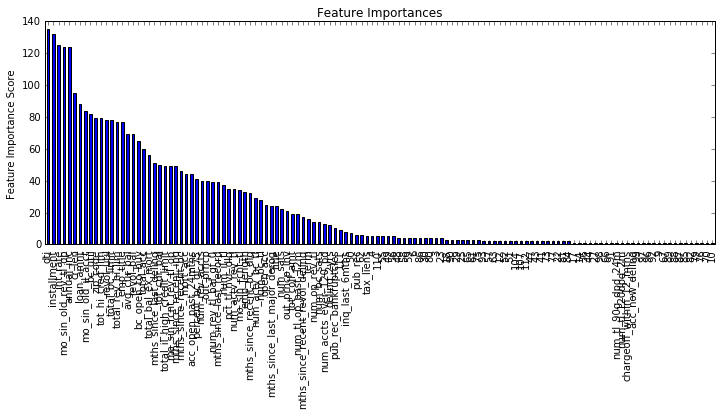

In [8]:
xgb_fit(xgb6, train_freq_loans, test_freq_loans, predictors, 'loan_status')

### Bayesian Optimization

In [57]:
from bayes_opt import BayesianOptimization

In [97]:
xgb_bound = {'max_depth': (4,6), 'subsample': (0.6,0.8), 'colsample_bytree': (0.4,0.6), 'reg_alpha': (0.01,1)}

In [106]:
def xgb_cv(max_depth, subsample, colsample_bytree, reg_alpha):
    xgb_clf = XGBClassifier(n_estimators=132, learning_rate=0.1, objective='binary:logistic', nthread=8, seed=27)
    xgb_clf.set_params(max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree, reg_alpha=reg_alpha)
    return cross_val_score(xgb_clf,
                            train_freq_loans[predictors], 
                            train_freq_loans['loan_status'], cv=3, scoring='roc_auc', n_jobs=-1).mean()

In [107]:
xgbBO = BayesianOptimization(xgb_cv, xgb_bound)
xgbBO.init(2)
# xgbBO.explore() define user points
xgbBO.maximize()
print('-'*53)
print('Final Results')
print('xgb: %f' % xgbBO.res['max']['max_val'])

    1 | 00m27s |    0.78771 |             0.4602 |      4.4103 |      0.3065 |      0.7953 | 
    2 | 00m34s |    0.78722 |             0.5933 |      4.1723 |      0.2356 |      0.6851 | 
Bayesian Optimization
--------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_depth |   reg_alpha |   subsample | 
    3 | 00m45s |    0.78696 |             0.5915 |      5.1583 |      0.7125 |      0.6647 | 
    4 | 00m28s |    0.78761 |             0.4504 |      4.4897 |      0.2465 |      0.7900 | 
    5 | 00m27s |    0.78710 |             0.4398 |      4.3033 |      0.3853 |      0.8000 | 
    6 | 00m28s |    0.78757 |             0.4608 |      4.4893 |      0.2475 |      0.7908 | 
    7 | 00m28s |    0.78791 |             0.4297 |      4.4962 |      0.3446 |      0.6299 | 
    8 | 00m29s |    0.78700 |             0.4256 |      4.4852 |      0.3268 |      0.6696 | 
    9 | 00m30s |    0.78726 |          

### Use the optimal parameters to fit the model

In [9]:
xgb7 = XGBClassifier(learning_rate = 0.1, 
                     n_estimators=132, 
                     max_depth=5, 
                     min_child_weight=1, 
                     gamma=0, 
                     subsample=0.6299, 
                     colsample_bytree=0.4297, 
                     objective= 'binary:logistic',
                     reg_alpha=0.3446,
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

Will train until cv error hasn't decreased in 50 rounds.


--- 121.665740967 seconds ---

Model Performance
Accuracy : 0.8067
AUC Score (Train): 0.822431
AUC Score (Test): 0.822673


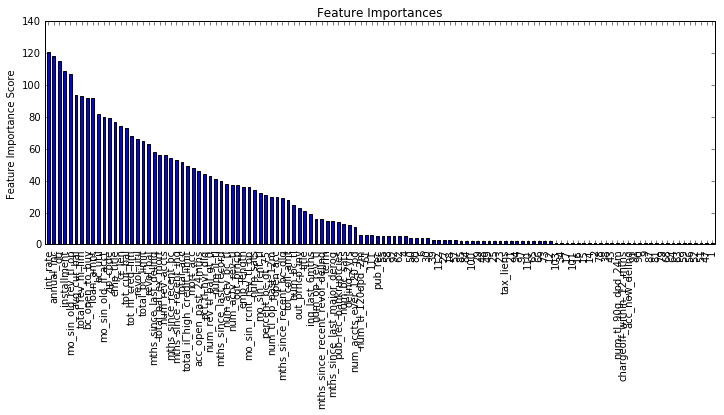

In [10]:
xgb_fit(xgb7, train_freq_loans, test_freq_loans, predictors, 'loan_status')